In [24]:
import ee

# Trigger the authentication flow.
# ee.Authenticate()

ee.Initialize(project='ee-arzaaan789')

In [27]:
import pandas as pd
from tqdm import tqdm

df = pd.read_csv("Pipistrellus pygmaeus.csv", delimiter='\t')
df = df[df["occurrenceStatus"] == "PRESENT"]
df = df[df['year']>=2022]
# df['eventDate'] = df['eventDate'].str.replace('/','')
df['eventDate'] = pd.to_datetime(df['eventDate'], format='%Y-%m-%d', errors='coerce')
df = df[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
df = df.dropna().reset_index(drop=True)
df.head()

,species,decimalLatitude,decimalLongitude,eventDate
0,Pipistrellus pygmaeus,54.311602,-0.751413,2022-09-01
1,Pipistrellus pygmaeus,50.727018,-2.157749,2022-08-14
2,Pipistrellus pygmaeus,54.336744,-0.727657,2022-09-01
3,Pipistrellus pygmaeus,55.283355,-2.532415,2022-08-20
4,Pipistrellus pygmaeus,50.727475,-2.165245,2022-08-14


In [28]:
import ee
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

# ee.Initialize()

# Your dataframe 'df' must have columns: decimalLongitude, decimalLatitude
# Example: df = pd.read_csv("Erinaceus europaeus.csv", delimiter='\t')

def create_aoi(lon, lat, box_size_km=1):
    """Create approx 1km x 1km square polygon around lon, lat."""
    half_side_deg = box_size_km / 111.32 / 2  # Rough approx degrees per km

    coords = [
        [lon - half_side_deg, lat - half_side_deg],
        [lon + half_side_deg, lat - half_side_deg],
        [lon + half_side_deg, lat + half_side_deg],
        [lon - half_side_deg, lat + half_side_deg],
        [lon - half_side_deg, lat - half_side_deg]
    ]
    return ee.Geometry.Polygon(coords)

def compute_all_indices(feature, start_date, end_date):
    """Compute spectral indices and LST for one EE Feature (with AOI geometry)."""
    aoi = feature.geometry()

    s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
          .filterBounds(aoi)
          .filterDate(start_date, end_date)
          .sort('CLOUDY_PIXEL_PERCENTAGE')
          .first())
    s2 = ee.Image(s2).clip(aoi)

    blue = s2.select('B2')
    green = s2.select('B3')
    red = s2.select('B4')
    nir = s2.select('B8')
    swir = s2.select('B11')

    L = 0.5  # SAVI constant

    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
    ndbi = swir.subtract(nir).divide(swir.add(nir)).rename('NDBI')
    savi = nir.subtract(red).divide(nir.add(red).add(L)).multiply(1 + L).rename('SAVI')
    mndwi = green.subtract(swir).divide(green.add(swir)).rename('MNDWI')
    ndsi = green.subtract(swir).divide(green.add(swir)).rename('NDSI')
    bsi = (red.add(blue).subtract(nir.add(swir))).divide(red.add(blue).add(nir).add(swir)).rename('BSI')
    ui = nir.subtract(swir).divide(nir.add(swir)).rename('UI')

    reducers = ee.Reducer.mean()
    scale_10m = 1000

    ndvi_mean = ndvi.reduceRegion(reducers, aoi, scale_10m).get('NDVI')
    ndwi_mean = ndwi.reduceRegion(reducers, aoi, scale_10m).get('NDWI')
    ndbi_mean = ndbi.reduceRegion(reducers, aoi, scale_10m).get('NDBI')
    savi_mean = savi.reduceRegion(reducers, aoi, scale_10m).get('SAVI')
    mndwi_mean = mndwi.reduceRegion(reducers, aoi, scale_10m).get('MNDWI')
    ndsi_mean = ndsi.reduceRegion(reducers, aoi, scale_10m).get('NDSI')
    bsi_mean = bsi.reduceRegion(reducers, aoi, scale_10m).get('BSI')
    ui_mean = ui.reduceRegion(reducers, aoi, scale_10m).get('UI')

    # MODIS LST dataset
    modis = (ee.ImageCollection("MODIS/061/MOD11A1")
             .filterBounds(aoi)
             .filterDate(start_date, end_date)
             .select('LST_Day_1km'))

    lst_mean_img = modis.mean().multiply(0.02).clip(aoi)

    lst_mean = lst_mean_img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=1000
    ).get('LST_Day_1km')

    return feature.set({
        'NDVI': ndvi_mean,
        'NDWI': ndwi_mean,
        'NDBI': ndbi_mean,
        'SAVI': savi_mean,
        'MNDWI': mndwi_mean,
        'NDSI': ndsi_mean,
        'BSI': bsi_mean,
        'UI': ui_mean,
        'LST': lst_mean
    })

# Split df into batches
batch_size = 50
batches = [df.iloc[i:i+batch_size] for i in range(0, len(df), batch_size)]

results_list = []

index_names = ['NDVI', 'NDWI', 'NDBI', 'SAVI', 'MNDWI', 'NDSI', 'BSI', 'UI', 'LST']

for batch in tqdm(batches, desc="Processing batches"):
    features = []
    batch_indices = []
    feature_metadata = {}

    for idx, row in batch.iterrows():
        
        aoi = create_aoi(row['decimalLongitude'], row['decimalLatitude'])
        feature = ee.Feature(aoi).set('index', idx)
        features.append(feature)
        batch_indices.append(idx)  # Save the original index
        
        event_date = row['eventDate']
        start_date = (event_date - timedelta(days=15)).strftime('%Y-%m-%d')
        end_date = (event_date + timedelta(days=15)).strftime('%Y-%m-%d')
        feature_metadata[idx] = (start_date, end_date)

    # Create a FeatureCollection from the list of features
    fc = ee.FeatureCollection(features)
    
    # Define wrapper for map to inject per-feature dates
    def map_with_dates(f):
        idx = f.get('index')
        # Use dictionary lookup to get dates for this feature
        date_dict = ee.Dictionary(ee.Dictionary(feature_metadata))
        dates = ee.List(date_dict.get(ee.Number(idx)))
        return compute_all_indices(f, dates.get(0), dates.get(1))

    try:
        result_fc = fc.map(map_with_dates)
        results = result_fc.getInfo()

        rows = []
        for f in results['features']:
            props = f['properties']
            rows.append(props)

    except Exception as e:
        print(f"Error processing batch starting at index {batch.index[0]}: {e}")
        # If there's an error, create placeholder rows with None
        rows = [{'index': i, **{name: None for name in index_names}} for i in batch_indices]

    batch_results_df = pd.DataFrame(rows).sort_values('index').reset_index(drop=True)
    results_list.append(batch_results_df)

# Concatenate all batches and sort by original index
all_results_df = pd.concat(results_list).sort_values('index').reset_index(drop=True)

# Merge with original df
df_final = pd.concat([df.reset_index(drop=True), all_results_df.drop(columns=['index'])], axis=1)

print(df_final.head())


Processing batches: 100%|██████████| 112/112 [05:08<00:00,  2.76s/it]

                 species  decimalLatitude  decimalLongitude  eventDate  \
0  Pipistrellus pygmaeus        54.311602         -0.751413 2022-09-01   
1  Pipistrellus pygmaeus        50.727018         -2.157749 2022-08-14   
2  Pipistrellus pygmaeus        54.336744         -0.727657 2022-09-01   
3  Pipistrellus pygmaeus        55.283355         -2.532415 2022-08-20   
4  Pipistrellus pygmaeus        50.727475         -2.165245 2022-08-14   

        BSI         LST     MNDWI      NDBI      NDSI      NDVI      NDWI  \
0 -0.692737  292.908264 -0.472662 -0.327387 -0.472662  0.777469 -0.692830   
1 -0.721747  304.522898 -0.590962 -0.178125 -0.590962  0.733947 -0.695415   
2 -0.772899  290.637920 -0.473247 -0.460535 -0.473247  0.848369 -0.766731   
3 -0.850200  295.399599 -0.494898 -0.529027 -0.494898  0.891343 -0.811517   
4 -0.695184  304.637333 -0.594975 -0.120916 -0.594975  0.687739 -0.667611   

       SAVI        UI  
0  1.165866  0.327387  
1  1.100761  0.178125  
2  1.272334  0.46053

In [29]:
df_final.to_csv("bat_full_data.csv", index=False)
df = pd.read_csv("bat_full_data.csv")
df['eventDate'] = pd.to_datetime(df['eventDate'], format='%Y-%m-%d', errors='coerce')

df = df.dropna().reset_index(drop=True)

In [30]:
ceratopogonidae = pd.read_csv("Ceratopogonidae.csv", delimiter='\t')
ceratopogonidae = ceratopogonidae[ceratopogonidae["occurrenceStatus"] == "PRESENT"]
ceratopogonidae = ceratopogonidae[ceratopogonidae['year']>=2022]
ceratopogonidae['eventDate'] = pd.to_datetime(ceratopogonidae['eventDate'], format='%Y-%m-%d', errors='coerce')
ceratopogonidae = ceratopogonidae[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
ceratopogonidae = ceratopogonidae.dropna().reset_index(drop=True)

chironomidae = pd.read_csv("Chironomidae.csv", delimiter='\t')
chironomidae = chironomidae[chironomidae["occurrenceStatus"] == "PRESENT"]
chironomidae = chironomidae[chironomidae['year']>=2022]
chironomidae['eventDate'] = pd.to_datetime(chironomidae['eventDate'], format='%Y-%m-%d', errors='coerce')
chironomidae = chironomidae[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
chironomidae = chironomidae.dropna().reset_index(drop=True)

cats = pd.read_csv("cats.csv", delimiter='\t')
cats = cats[cats["occurrenceStatus"] == "PRESENT"]
cats = cats[cats['year']>=2022]
cats['eventDate'] = pd.to_datetime(cats['eventDate'], format='%Y-%m-%d', errors='coerce')
cats = cats[['species', 'decimalLatitude', 'decimalLongitude', 'eventDate']]
cats = cats.dropna().reset_index(drop=True)


wind_turbines = pd.read_excel("REPD_202407_WIND.xlsx")
wind_turbines = wind_turbines[wind_turbines['DEVSTATSHT']=='Operational']
wind_turbines = wind_turbines[['LAT','LNG']]
wind_turbines = wind_turbines.rename(columns={'LAT': 'decimalLatitude', 'LNG': 'decimalLongitude'})
wind_turbines = wind_turbines.dropna().reset_index(drop=True)

In [31]:
import numpy as np
from sklearn.neighbors import BallTree

# Convert lat/lon to radians for BallTree
bat_coords = np.deg2rad(df[['decimalLatitude', 'decimalLongitude']].values)
ceratopogonidae_coords = np.deg2rad(ceratopogonidae[['decimalLatitude', 'decimalLongitude']].values)
chironomidae_coords = np.deg2rad(chironomidae[['decimalLatitude', 'decimalLongitude']].values)
cats_coords = np.deg2rad(cats[['decimalLatitude', 'decimalLongitude']].values)
wind_turbines_coords = np.deg2rad(wind_turbines[['decimalLatitude', 'decimalLongitude']].values)

# Build BallTree using haversine metric
tree_ceratopogonidae = BallTree(ceratopogonidae_coords, metric='haversine')
tree_chironomidae = BallTree(chironomidae_coords, metric='haversine')
tree_cats = BallTree(cats_coords, metric='haversine')
tree_wind_turbines = BallTree(wind_turbines_coords, metric='haversine')

# Define search radius: 1 km in radians
earth_radius_km = 6371.0
radius = 1 / earth_radius_km  # 1 km in radians

# Initialize presence columns
df['ceratopogonidae_presence'] = 0
df['chironomidae_presence'] = 0
df['cats_presence'] = 0

# Iterate through each bat point with tqdm for progress tracking
for i in tqdm(range(len(df))):
    point = bat_coords[i].reshape(1, -1)
    event_month = df.loc[i, 'eventDate'].month
    event_year = df.loc[i, 'eventDate'].year

    # CERATOPOGONIDAE
    idxs = tree_ceratopogonidae.query_radius(point, r=radius)[0]
    for j in idxs:
        ceratopogonidae_date = ceratopogonidae.loc[j, 'eventDate']
        if ceratopogonidae_date.month == event_month and ceratopogonidae_date.year == event_year:
            df.at[i, 'ceratopogonidae_presence'] = 1
            break  # Found at least one match, no need to check further

    # CHIRONOMIDAE
    idxs = tree_chironomidae.query_radius(point, r=radius)[0]
    for j in idxs:
        chironomidae_date = chironomidae.loc[j, 'eventDate']
        if chironomidae_date.month == event_month and chironomidae_date.year == event_year:
            df.at[i, 'chironomidae_presence'] = 1
            break  # Found at least one match, no need to check further
            
    # CATS
    idxs = tree_cats.query_radius(point, r=radius)[0]
    for j in idxs:
        cats_date = cats.loc[j, 'eventDate']
        if cats_date.month == event_month and cats_date.year == event_year:
            df.at[i, 'cats_presence'] = 1
            break  # Found at least one match, no need to check further
        
indices = tree_wind_turbines.query_radius(bat_coords, r=radius)
df['wind_turbines_presence'] = [1 if len(neighbors) > 0 else 0 for neighbors in indices]

100%|██████████| 5459/5459 [00:00<00:00, 7303.94it/s]


In [32]:
import osmnx as ox
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
from tqdm import tqdm

# Construct GeoDataFrame
df['geometry'] = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Define spatial tiling: 0.05 x 0.05 degrees
tile_size_lat = 0.009   # ~1 km in latitude degrees
tile_size_lon = 0.0157  # ~1 km in longitude degrees
padding_lat = 0.002  # ~200m latitude padding
padding_lon = 0.003  # ~200-300m longitude padding

gdf['tile_x'] = (gdf['decimalLongitude'] // tile_size_lon).astype(int)
gdf['tile_y'] = (gdf['decimalLatitude'] // tile_size_lat).astype(int)

# Group by tile
grouped = gdf.groupby(['tile_x', 'tile_y'])

# Store results
all_distances = []

for (tile_x, tile_y), group in tqdm(grouped, total=len(grouped)):
    west = tile_x * tile_size_lon - padding_lon
    south = tile_y * tile_size_lat - padding_lat
    east = (tile_x + 1) * tile_size_lon + padding_lon
    north = (tile_y + 1) * tile_size_lat + padding_lat
    bbox = (west, south, east, north)


    try:
        G = ox.graph_from_bbox(bbox, network_type='drive_service')
        if len(G.nodes) == 0:
            print(f"[EMPTY GRAPH] bbox: {bbox}, skipping...")
            all_distances.extend([np.nan] * len(group))
            continue

        G_proj = ox.project_graph(G)
        nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj)
        points_proj = group.geometry.to_crs(nodes_proj.crs)

        for point_proj in points_proj:
            try:
                u, v, k = ox.distance.nearest_edges(G_proj, [point_proj.x], [point_proj.y])[0]
                edge_geom = edges_proj.loc[(u, v, k)]['geometry']
                distance = point_proj.distance(edge_geom)
                all_distances.append(distance)
            except Exception as e:
                print(f"  [Point ERROR] {e}")
                all_distances.append(np.nan)

    except Exception as e:
        print(f"[TILE ERROR] {e} — bbox: {bbox}")
        all_distances.extend([np.nan] * len(group))


# Store back in original DataFrame order
gdf['distance_to_road'] = all_distances

  1%|          | 11/1323 [00:02<04:30,  4.86it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-5.9533), np.float64(57.03099999999999), np.float64(-5.9315999999999995), np.float64(57.044))
[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-5.9533), np.float64(57.03999999999999), np.float64(-5.9315999999999995), np.float64(57.053))


  4%|▎         | 47/1323 [00:14<06:11,  3.43it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-4.697299999999999), np.float64(51.882999999999996), np.float64(-4.675599999999999), np.float64(51.896))


  4%|▍         | 56/1323 [00:17<05:51,  3.61it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-4.556), np.float64(51.80199999999999), np.float64(-4.534299999999999), np.float64(51.815))


  5%|▌         | 70/1323 [00:21<04:41,  4.45it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-4.3519), np.float64(51.77499999999999), np.float64(-4.3302), np.float64(51.788))


  6%|▌         | 78/1323 [00:23<05:01,  4.13it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-4.2577), np.float64(51.62199999999999), np.float64(-4.236), np.float64(51.635))


  6%|▋         | 84/1323 [00:25<05:19,  3.88it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-4.1792), np.float64(53.06199999999999), np.float64(-4.1575), np.float64(53.074999999999996))


  8%|▊         | 104/1323 [00:31<04:59,  4.06it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-4.0379), np.float64(53.160999999999994), np.float64(-4.0161999999999995), np.float64(53.174))


  8%|▊         | 107/1323 [00:33<06:10,  3.28it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-4.0222), np.float64(52.980999999999995), np.float64(-4.0005), np.float64(52.994))


  8%|▊         | 109/1323 [00:33<05:58,  3.39it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-4.0065), np.float64(52.53099999999999), np.float64(-3.9847999999999995), np.float64(52.544))


 10%|▉         | 129/1323 [00:41<07:26,  2.68it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-3.928), np.float64(52.38699999999999), np.float64(-3.9062999999999994), np.float64(52.4))


 10%|█         | 136/1323 [00:43<05:42,  3.47it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-3.8337999999999997), np.float64(52.17099999999999), np.float64(-3.8120999999999996), np.float64(52.184))


 11%|█         | 141/1323 [00:44<04:31,  4.36it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.8181), np.float64(51.81099999999999), np.float64(-3.7963999999999998), np.float64(51.824))


 12%|█▏        | 157/1323 [00:50<06:59,  2.78it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-3.5826), np.float64(52.55799999999999), np.float64(-3.5608999999999997), np.float64(52.571))


 13%|█▎        | 172/1323 [00:55<05:02,  3.81it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-3.4884), np.float64(54.96999999999999), np.float64(-3.4666999999999994), np.float64(54.983))


 14%|█▍        | 184/1323 [00:58<05:20,  3.56it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.3941999999999997), np.float64(52.062999999999995), np.float64(-3.3724999999999996), np.float64(52.076))


 14%|█▍        | 188/1323 [00:59<04:53,  3.87it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.3941999999999997), np.float64(54.528999999999996), np.float64(-3.3724999999999996), np.float64(54.542))


 15%|█▍        | 195/1323 [01:01<04:58,  3.78it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.3785), np.float64(56.175999999999995), np.float64(-3.3568), np.float64(56.189))


 15%|█▌        | 201/1323 [01:04<05:51,  3.20it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-3.3470999999999997), np.float64(51.900999999999996), np.float64(-3.3253999999999997), np.float64(51.914))


 16%|█▌        | 213/1323 [01:08<06:35,  2.81it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-3.2843), np.float64(53.169999999999995), np.float64(-3.2625999999999995), np.float64(53.183))


 17%|█▋        | 221/1323 [01:11<07:03,  2.60it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-3.2371999999999996), np.float64(51.459999999999994), np.float64(-3.2154999999999996), np.float64(51.473))


 25%|██▌       | 331/1323 [02:47<13:20,  1.24it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.8604), np.float64(53.32299999999999), np.float64(-2.8387), np.float64(53.336))


 27%|██▋       | 361/1323 [03:20<12:12,  1.31it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.7976), np.float64(54.16), np.float64(-2.7758999999999996), np.float64(54.173))


 28%|██▊       | 368/1323 [03:26<11:44,  1.36it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.7662), np.float64(52.33299999999999), np.float64(-2.7444999999999995), np.float64(52.346))


 33%|███▎      | 434/1323 [04:35<12:56,  1.14it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5778), np.float64(55.266999999999996), np.float64(-2.5561), np.float64(55.28))


 33%|███▎      | 437/1323 [04:37<10:07,  1.46it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5621), np.float64(55.239999999999995), np.float64(-2.5403999999999995), np.float64(55.253))


 33%|███▎      | 438/1323 [04:38<08:46,  1.68it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5621), np.float64(55.248999999999995), np.float64(-2.5403999999999995), np.float64(55.262))


 33%|███▎      | 439/1323 [04:38<07:53,  1.87it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5621), np.float64(55.285), np.float64(-2.5403999999999995), np.float64(55.297999999999995))


 34%|███▎      | 444/1323 [04:44<12:52,  1.14it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5463999999999998), np.float64(55.239999999999995), np.float64(-2.5246999999999997), np.float64(55.253))


 34%|███▎      | 445/1323 [04:44<10:54,  1.34it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5463999999999998), np.float64(55.248999999999995), np.float64(-2.5246999999999997), np.float64(55.262))


 34%|███▎      | 446/1323 [04:45<09:27,  1.55it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5463999999999998), np.float64(55.266999999999996), np.float64(-2.5246999999999997), np.float64(55.28))


 34%|███▍      | 447/1323 [04:45<08:26,  1.73it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5463999999999998), np.float64(55.275999999999996), np.float64(-2.5246999999999997), np.float64(55.289))


 34%|███▍      | 448/1323 [04:46<07:39,  1.90it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5463999999999998), np.float64(55.285), np.float64(-2.5246999999999997), np.float64(55.297999999999995))


 35%|███▍      | 462/1323 [04:58<10:27,  1.37it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.5149999999999997), np.float64(55.266999999999996), np.float64(-2.4932999999999996), np.float64(55.28))


 35%|███▌      | 465/1323 [05:00<09:22,  1.52it/s]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-2.4993), np.float64(55.275999999999996), np.float64(-2.4776), np.float64(55.289))


 36%|███▌      | 470/1323 [05:04<10:54,  1.30it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.4836), np.float64(53.43999999999999), np.float64(-2.4618999999999995), np.float64(53.452999999999996))


 36%|███▌      | 471/1323 [05:04<10:02,  1.42it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.4836), np.float64(57.06699999999999), np.float64(-2.4618999999999995), np.float64(57.08))


 37%|███▋      | 492/1323 [05:24<10:22,  1.33it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.3737), np.float64(52.37799999999999), np.float64(-2.352), np.float64(52.391))


 41%|████▏     | 546/1323 [06:29<23:32,  1.82s/it]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.1853), np.float64(50.730999999999995), np.float64(-2.1635999999999997), np.float64(50.744))


 42%|████▏     | 553/1323 [06:35<12:27,  1.03it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-2.1696), np.float64(50.730999999999995), np.float64(-2.1479), np.float64(50.744))


 43%|████▎     | 563/1323 [06:47<11:30,  1.10it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.1382), np.float64(50.712999999999994), np.float64(-2.1165), np.float64(50.726))


 43%|████▎     | 571/1323 [06:56<12:38,  1.01s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.1382), np.float64(53.99799999999999), np.float64(-2.1165), np.float64(54.010999999999996))


 43%|████▎     | 573/1323 [06:58<09:53,  1.26it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.1225), np.float64(50.721999999999994), np.float64(-2.1007999999999996), np.float64(50.735))


 46%|████▌     | 606/1323 [07:35<11:22,  1.05it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-2.0126), np.float64(52.76499999999999), np.float64(-1.9909), np.float64(52.778))


 48%|████▊     | 632/1323 [08:00<15:22,  1.33s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.8555999999999997), np.float64(51.01899999999999), np.float64(-1.8338999999999999), np.float64(51.032))


 48%|████▊     | 639/1323 [08:16<17:48,  1.56s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.8398999999999996), np.float64(50.88399999999999), np.float64(-1.8182), np.float64(50.897))


 56%|█████▌    | 740/1323 [10:15<10:53,  1.12s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.3531999999999997), np.float64(52.87299999999999), np.float64(-1.3315), np.float64(52.885999999999996))


 60%|██████    | 794/1323 [11:33<09:38,  1.09s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.2118999999999998), np.float64(53.32299999999999), np.float64(-1.1902), np.float64(53.336))


 61%|██████    | 802/1323 [11:47<14:10,  1.63s/it]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-1.1804999999999999), np.float64(52.71099999999999), np.float64(-1.1588), np.float64(52.724))


 61%|██████    | 807/1323 [11:52<08:53,  1.03s/it]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-1.1647999999999998), np.float64(51.81099999999999), np.float64(-1.1431), np.float64(51.824))


 63%|██████▎   | 836/1323 [12:35<11:04,  1.36s/it]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-1.1019999999999999), np.float64(53.151999999999994), np.float64(-1.0803), np.float64(53.165))


 64%|██████▎   | 842/1323 [12:44<08:57,  1.12s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.0862999999999998), np.float64(53.13399999999999), np.float64(-1.0646), np.float64(53.147))


 64%|██████▍   | 851/1323 [12:54<07:53,  1.00s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-1.0548999999999997), np.float64(51.702999999999996), np.float64(-1.0332000000000001), np.float64(51.716))


 65%|██████▌   | 864/1323 [13:07<08:08,  1.06s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.9920999999999999), np.float64(53.160999999999994), np.float64(-0.9703999999999999), np.float64(53.174))


 69%|██████▉   | 910/1323 [14:04<06:36,  1.04it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.8193999999999999), np.float64(52.611999999999995), np.float64(-0.7977), np.float64(52.625))


 70%|██████▉   | 925/1323 [14:26<10:09,  1.53s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.7879999999999999), np.float64(54.312999999999995), np.float64(-0.7663), np.float64(54.326))


 71%|███████   | 933/1323 [14:41<10:30,  1.62s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.7723), np.float64(54.312999999999995), np.float64(-0.7505999999999999), np.float64(54.326))


 71%|███████▏  | 943/1323 [15:00<11:05,  1.75s/it]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.7565999999999999), np.float64(54.321999999999996), np.float64(-0.7348999999999999), np.float64(54.335))


 72%|███████▏  | 947/1323 [15:06<09:49,  1.57s/it]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.7408999999999999), np.float64(53.224), np.float64(-0.7192), np.float64(53.237))


 72%|███████▏  | 948/1323 [15:08<09:18,  1.49s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.7408999999999999), np.float64(54.321999999999996), np.float64(-0.7192), np.float64(54.335))


 72%|███████▏  | 949/1323 [15:10<10:56,  1.76s/it]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.7408999999999999), np.float64(54.330999999999996), np.float64(-0.7192), np.float64(54.344))


 72%|███████▏  | 950/1323 [15:11<10:07,  1.63s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.7408999999999999), np.float64(54.339999999999996), np.float64(-0.7192), np.float64(54.353))


 72%|███████▏  | 957/1323 [15:27<11:35,  1.90s/it]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-0.7252), np.float64(54.330999999999996), np.float64(-0.7034999999999999), np.float64(54.344))


 72%|███████▏  | 958/1323 [15:28<10:22,  1.70s/it]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-0.7252), np.float64(54.349), np.float64(-0.7034999999999999), np.float64(54.362))


 74%|███████▍  | 985/1323 [16:26<10:36,  1.88s/it]

[TILE ERROR] No data elements in server response. Check query location/filters and log. — bbox: (np.float64(-0.6780999999999999), np.float64(54.25899999999999), np.float64(-0.6564), np.float64(54.272))


 78%|███████▊  | 1026/1323 [18:05<10:16,  2.07s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.5525), np.float64(54.276999999999994), np.float64(-0.5307999999999999), np.float64(54.29))


 78%|███████▊  | 1027/1323 [18:06<09:15,  1.88s/it]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.5525), np.float64(54.330999999999996), np.float64(-0.5307999999999999), np.float64(54.344))


 80%|███████▉  | 1056/1323 [19:13<09:40,  2.17s/it]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(-0.37979999999999997), np.float64(50.964999999999996), np.float64(-0.3581), np.float64(50.978))


 83%|████████▎ | 1093/1323 [20:48<07:41,  2.01s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.28559999999999997), np.float64(51.44199999999999), np.float64(-0.26389999999999997), np.float64(51.455))


 84%|████████▍ | 1113/1323 [21:44<08:58,  2.56s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.2542), np.float64(52.260999999999996), np.float64(-0.23249999999999998), np.float64(52.274))


 85%|████████▍ | 1120/1323 [22:03<08:00,  2.37s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.2385), np.float64(52.38699999999999), np.float64(-0.2168), np.float64(52.4))


 85%|████████▌ | 1128/1323 [22:25<08:32,  2.63s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(-0.1914), np.float64(50.88399999999999), np.float64(-0.1697), np.float64(50.897))


 92%|█████████▏| 1214/1323 [24:52<02:10,  1.19s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.1069), np.float64(52.099), np.float64(0.1286), np.float64(52.112))


 92%|█████████▏| 1218/1323 [24:59<02:25,  1.39s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.1069), np.float64(52.297), np.float64(0.1286), np.float64(52.309999999999995))


 95%|█████████▍| 1252/1323 [25:29<00:44,  1.61it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(0.3581), np.float64(51.06399999999999), np.float64(0.37979999999999997), np.float64(51.077))


 95%|█████████▍| 1254/1323 [25:30<00:41,  1.68it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.3581), np.float64(52.32399999999999), np.float64(0.37979999999999997), np.float64(52.336999999999996))


 96%|█████████▌| 1265/1323 [25:42<00:54,  1.06it/s]

[TILE ERROR] Graph contains no edges. — bbox: (np.float64(0.42089999999999994), np.float64(51.96399999999999), np.float64(0.4426), np.float64(51.977))


 96%|█████████▌| 1270/1323 [25:46<00:43,  1.22it/s]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(0.46799999999999997), np.float64(52.827999999999996), np.float64(0.48969999999999997), np.float64(52.841))


 99%|█████████▉| 1312/1323 [26:34<00:14,  1.31s/it]

[TILE ERROR] Found no graph nodes within the requested polygon. — bbox: (np.float64(1.1588), np.float64(51.22599999999999), np.float64(1.1804999999999999), np.float64(51.239))


100%|██████████| 1323/1323 [26:47<00:00,  1.21s/it]


In [33]:
gdf['near_road'] = np.where(gdf['distance_to_road'] <= 500, 1, 0)        

In [34]:
gdf=gdf.drop(['tile_x', 'tile_y', 'geometry', 'distance_to_road'], axis=1)

In [35]:
from pyproj import Transformer
from rasterio.windows import Window
import rasterio
from collections import Counter
import numpy as np


land_cover_map = {
    1: "Deciduous woodland",
    2: "Coniferous woodland",
    3: "Arable",
    4: "Improved grassland",
    5: "Neutral grassland",
    6: "Calcareous grassland",
    7: "Acid grassland",
    8: "Fen",
    9: "Heather",
    10: "Heather grassland",
    11: "Bog",
    12: "Inland rock",
    13: "Saltwater",
    14: "Freshwater",
    15: "Supralittoral rock",
    16: "Supralittoral sediment",
    17: "Littoral rock",
    18: "Littoral sediment",
    19: "Saltmarsh",
    20: "Urban",
    21: "Suburban"
}

# Batch coordinate transformation
transformer_ni = Transformer.from_crs("EPSG:4326", "EPSG:29903", always_xy=True)
transformer_gb = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)

coords = list(zip(gdf['decimalLongitude'], gdf['decimalLatitude']))
gdf['easting_ni'], gdf['northing_ni'] = zip(*transformer_ni.itransform(coords))
gdf['easting_gb'], gdf['northing_gb'] = zip(*transformer_gb.itransform(coords))

# Raster processing optimization
gb_raster = 'gblcm2023_10m.tif'
n_ireland_raster = 'nilcm2023_10m.tif'


def get_land_cover_class_1km(row):
    try:
        window_size_pixels = 100  # 1 km / 10m resolution

        # Open GB raster and read 1km x 1km window
        with rasterio.open(gb_raster) as src:
            row_idx, col_idx = src.index(row['easting_gb'], row['northing_gb'])

            # Calculate window bounds, making sure not to go out of raster bounds
            row_start = max(row_idx - window_size_pixels // 2, 0)
            col_start = max(col_idx - window_size_pixels // 2, 0)

            # Adjust window size if near edges
            height = min(window_size_pixels, src.height - row_start)
            width = min(window_size_pixels, src.width - col_start)

            window = Window(col_start, row_start, width, height)
            data = src.read(1, window=window)

            # If all zero (or no data), fallback to NI raster
            if np.all(data == 0):
                with rasterio.open(n_ireland_raster) as src_ni:
                    row_idx_ni, col_idx_ni = src_ni.index(row['easting_ni'], row['northing_ni'])

                    row_start_ni = max(row_idx_ni - window_size_pixels // 2, 0)
                    col_start_ni = max(col_idx_ni - window_size_pixels // 2, 0)

                    height_ni = min(window_size_pixels, src_ni.height - row_start_ni)
                    width_ni = min(window_size_pixels, src_ni.width - col_start_ni)

                    window_ni = Window(col_start_ni, row_start_ni, width_ni, height_ni)
                    data_ni = src_ni.read(1, window=window_ni)

                    data = data_ni

            # Find the most common class (mode) ignoring zeros (assuming 0 means no data)
            unique, counts = np.unique(data[data != 0], return_counts=True)
            if len(counts) == 0:
                return "Unknown"

            mode_class = unique[np.argmax(counts)]
            return land_cover_map.get(mode_class, "Unknown")

    except Exception as e:
        print(f"Error processing row: {e}")
        return "Unknown"


tqdm.pandas()
gdf['Land_cover'] = gdf.progress_apply(get_land_cover_class_1km, axis=1)


100%|██████████| 5459/5459 [02:09<00:00, 42.14it/s]


In [36]:
gdf = gdf.dropna()
gdf=gdf.drop(['easting_ni', 'northing_ni', 'easting_gb', 'northing_gb'],axis=1)
# Remove where Land_cover is Unknown
gdf = gdf[gdf['Land_cover'] != "Unknown"].reset_index(drop=True)
gdf.to_csv("bat_final_data.csv", index=False)

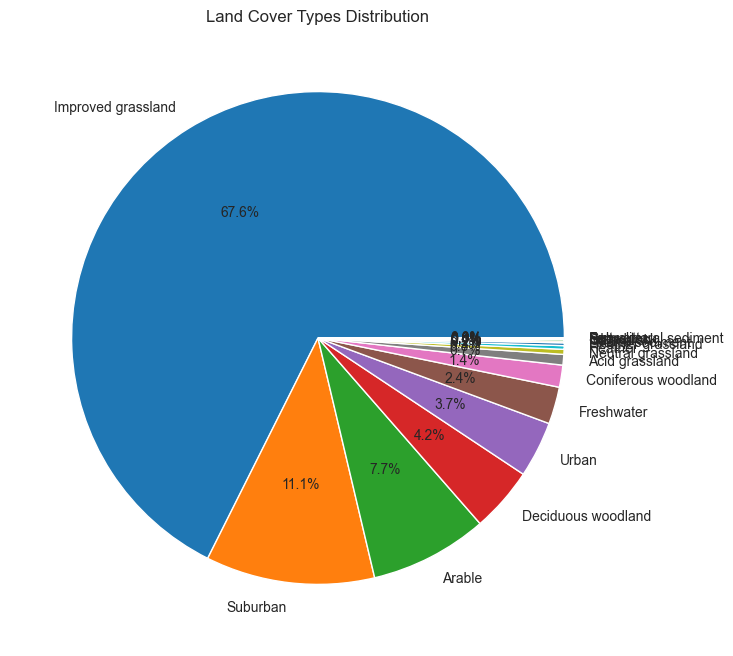

In [3]:
import pandas as pd
df = pd.read_csv("bat_final_data.csv")

import matplotlib.pyplot as plt
# df = df[df['probability'] > 0.6]

# #do inverse of one-hot encoding for columns starting with "Land_cover_"
# land_cover_cols = [col for col in df.columns if col.startswith('Land_cover_')]
# def get_land_cover(row):
#     for col in land_cover_cols:
#         if row[col] == 1:
#             return col.replace('Land_cover_', '')
#     return 'Unknown'
# df['Land_cover'] = df.apply(get_land_cover, axis=1)
# # df = df[['decimalLatitude', 'decimalLongitude', 'probability', 'Land_cover']]

# pie chart of land cover types
land_cover_counts = df['Land_cover'].value_counts()
land_cover_counts.plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Land Cover Types Distribution')
plt.ylabel('')
plt.show()
